In [1]:
import numpy as np
import networkx as nx
from dotmotif import Motif, GrandIsoExecutor
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.stats import ranksums
import statsmodels.stats.multitest as smm
import scipy
import ptitprince as pt
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy import stats
import seaborn as sns
from statannotations.Annotator import Annotator

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
from lsmm_data import LSMMData
import json

with open('all_cells_proofread_connectome.json') as f:
    loaded_json = json.load(f)
my_data = LSMMData.LSMMData(loaded_json)
tables = my_data.data
params = my_data.params
dirs = my_data.dirs
mappings = my_data.mappings
 
print(tables['structural']['pre_cell'])
print(tables['structural']['post_cell'])
print(tables['structural']['synapse'])
 
pt_root_id = tables['structural']['pre_cell'].iloc[1]['pt_root_id']
#print("Connectome Index.  Should be 41:", mappings['pt_root_id_to_connectome_index'][pt_root_id])

Generating Connectome...


100%|██████████| 137706/137706 [00:15<00:00, 8848.50it/s]


Generating Connectome...


100%|██████████| 137706/137706 [00:20<00:00, 6626.12it/s]


     level_0  index      id          pt_root_id  pt_position_x  pt_position_y  \
0         11   5343  265264  864691132808934303         760014         425481   
1         13   5341  265634  864691132732388891         736114         457840   
2         22   5267  265622  864691132690646038         882079         467618   
3         31    889  266587  864691132731513964         803393         444648   
4         41   5609  341272  864691132661462205         922664         410814   
..       ...    ...     ...                 ...            ...            ...   
847     8796   6024  274993  864691132618678215         832726         518601   
848     8797   2948  265362  864691132785809960         870672         457142   
849     8799   6362  294211  864691132653001075         825664         647572   
850     8804   1139  265241  864691132634898417         731225         334844   
851     8805   8393  264864  864691132893609430         750625         340897   

     pt_position_z classifi

In [3]:
'''---------------------When using LSMM-------------------------------------'''
cell_table = tables['structural']['pre_cell']

weight_matrix = tables['structural']['summed_size_connectome']

In [4]:
cell_table['pt_position_x_trafo'] = cell_table['pt_position_x_trafo']/1000
cell_table['pt_position_y_trafo'] = cell_table['pt_position_y_trafo']/1000
cell_table['pt_position_z_trafo'] = cell_table['pt_position_z_trafo']/1000

x_pos = np.mean(cell_table['pt_position_x_trafo'])   # Centroid of the graph - cartesian co-ordinates system hence, centroid = mean
y_pos = np.mean(cell_table['pt_position_y_trafo'])
z_pos = np.mean(cell_table['pt_position_z_trafo'])
cent_dist_no_a = []
cent_dist_a = []

x_pos, y_pos, z_pos

(-34.74530939045572, 361.8530747079696, -19.67626593543391)

In [5]:
n_assembly, n_nonassembly = 0, 0
for cell in mappings['assemblies_by_connectome_index']:
    if mappings['assemblies_by_connectome_index'][cell] == ['No A']:
        cent_dist_no_a.append(np.linalg.norm([cell_table['pt_position_x_trafo'][cell] -  x_pos, cell_table['pt_position_y_trafo'][cell] - y_pos], axis = 0))
        n_nonassembly += 1
    else:
        cent_dist_a.append(np.linalg.norm([cell_table['pt_position_x_trafo'][cell] - x_pos, cell_table['pt_position_y_trafo'][cell] -  y_pos], axis = 0))
        n_assembly += 1

/Users/jawagnercarena/opt/anaconda3/envs/assembly/lib/python3.10/site-packages/statannotations/Annotator.py:825: UserWarning: Annotator was reconfigured without applying the test (again) which will probably lead to unexpected results
  warnings.warn("Annotator was reconfigured without applying the "


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Assembly
(n=61) vs. Non-Assembly
(n=19): Custom statistical test, P_val:4.454e-01


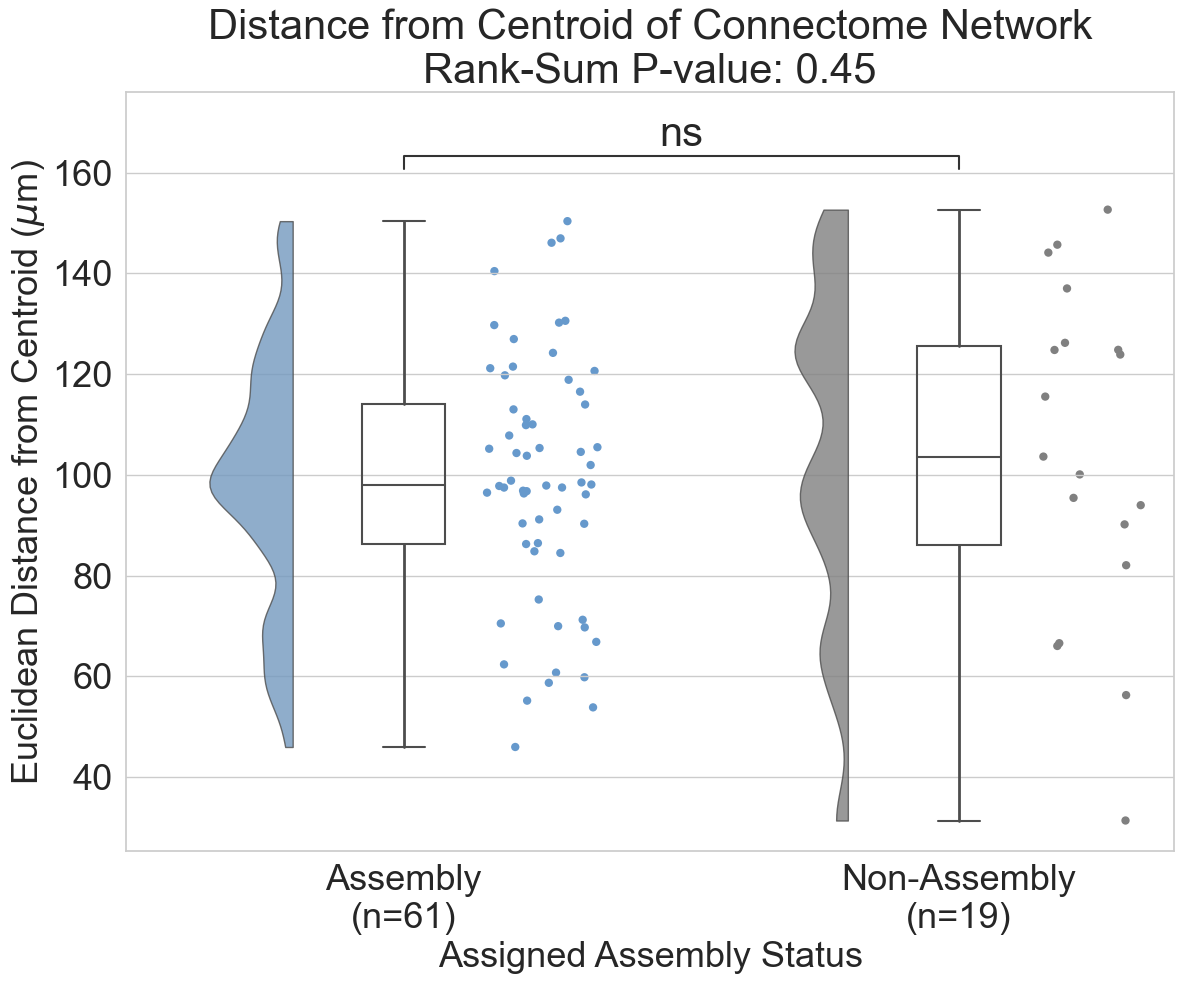

In [7]:
# Perform Test
stat, p_val = scipy.stats.ranksums(cent_dist_a, cent_dist_no_a)

# Calculate sample sizes
y_labels = [f"Assembly\n(n={n_assembly})", f"Non-Assembly\n(n={n_nonassembly})"]

# Build a frame for easier plotting
data = pd.DataFrame({
    "Values": np.concatenate([cent_dist_a, cent_dist_no_a]),
    "Group": [y_labels[0]] * n_assembly + [y_labels[1]] * n_nonassembly
})

# Set up the plot
plt.figure(figsize=(12, 10))
sns.set_theme(style="whitegrid")

# --- Main plot (original RainCloud) ---
ax = pt.RainCloud(
    y="Values",
    x="Group",
    data= data,
    palette=[(.4, .6, .8, .5), 'grey'],
    width_viol=0.3,
    alpha=0.8,
    move=0.25,
    point_size=6,
    orient="v",
)

# Annotate significance
pairs = [(y_labels[0], y_labels[1])]
annot = Annotator(ax, 
                    pairs,
                    data=data,
                    x="Group",
                    y="Values",
                    order=y_labels # Force the order
                    )
annot.set_pvalues([p_val])
annot.configure(text_format="star", loc="inside", fontsize=30)
annot.annotate()

# Axis title and labels
ax.set_title(f"Distance from Centroid of Connectome Network\nRank-Sum P-value: {p_val:.2g}", size=30)
ax.set_xlabel("Assigned Assembly Status", size=26)
ax.set_ylabel(r"Euclidean Distance from Centroid ($\mu$m)", size=26)
ax.tick_params(labelsize=26)
# ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

plt.tight_layout()
plt.savefig('draft_figures/a_vs_nona_distance_from_centroid.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()